see https://docs.aws.amazon.com/sagemaker/latest/dg/augmented-manifest.html

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import json
import sagemaker 
import boto3
import os
import cv2

# Sagemaker session
sess = sagemaker.Session()
# get session bucket name
bucket = sess.default_bucket()
s3 = boto3.resource('s3')
s3_client = boto3.client('s3', region_name='us-west-2')

print(f"default_bucket: {bucket}")

default_bucket: sagemaker-us-west-2-287314575097


In [6]:
# !python3 -m pip install --upgrade pip
# !pip install opencv-contrib-python

import boto3
s3 = boto3.resource('s3')
from matplotlib import pyplot as plt
import cv2
import numpy as np
from plot_hist_lib.plot_image_histogram import plotImageHistogram

def process_image(img_bucket: str, img_key: str, title: str) -> np.ndarray:
    try:
        img_body = s3.Bucket(img_bucket).Object(img_key).get()['Body'].read()
        img_data = np.asarray(bytearray(img_body), dtype="uint8")
        image = cv2.imdecode(img_data, cv2.IMREAD_COLOR)
        print(f"image key:{img_key} shape:{image.shape}")

        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        # display the RGB image
        plt.figure()
        plt.imshow(rgb_image)
        plt.title(title)
        plt.show()

        # convert color image to gray_image
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # standardize the gray image (so mu=0,std=1) and plot its histogram 
        plotImageHistogram(gray_image)

        return hsv_image
    except Exception as e:
        if type(e).__name__ == "NoSuchKey":
            return None
        else:
            print(f"Exception {e} for img_bucket:{img_bucket} img_key:{img_key}")
            return None
    

In [7]:
# download and parse manifest file

def process_manifest_file(manifest_bucket: str, manifest_key: str, skip_frames: int=0, max_frames: int=0) -> None:
    '''
    download manifest file, parse and process stamp images from each line
    
    Example:
        manifest_bucket = "media.angel-nft.com"
        manifest_key = os.path.join('tuttle_twins/manifest', 'TT-S01-E01.csv')
        process_manifest_file(manifest_bucket, manifest_key)
    '''
    manifest_bucket = "media.angel-nft.com"
    manifest_obj = s3.Bucket(manifest_bucket).Object(manifest_key)
    manifest_contents = manifest_obj.get()['Body'].read().decode("utf-8-sig")

    img_bucket = manifest_bucket

    import io
    manifest_lines = io.StringIO(manifest_contents).readlines()

    frame_count = 0
    for json_str in manifest_lines:
        if (skip_frames == 0) or (frame_count % skip_frames == 0):
            line_dict = json.loads(json_str)
            img_url = line_dict.get("src-ref")
            stamp_url = img_url.replace("thumbnails","stamps")
            img_key = img_url.replace("https://s3.us-west-2.amazonaws.com/media.angel-nft.com/", "")
            stamp_key = img_key.replace("thumbnails","stamps")
            img_class = line_dict.get("class")
            # print(f"thumbnail_url: {img_url}")
            # print(f"stamp_url: {stamp_url}")
            # print(f"img_key: {img_key}")
            # print(f"img_class: {img_class}")
            # process_image(img_bucket, img_key)

            hsv_image = process_image(img_bucket, stamp_key, f"frame {frame_count} ({img_class}")
            if hsv_image is None:
                break

        frame_count += 1
        if (max_frames > 0) and (frame_count > max_frames):
            break



image key:tuttle_twins/s01e01/default_eng/v1/frames/stamps/TT_S01_E01_FRM-00-00-08-09.jpg shape:(36, 64, 3)


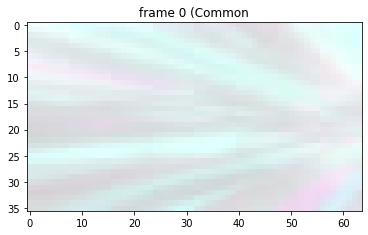

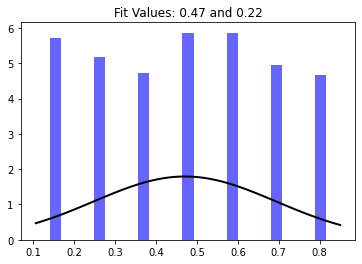

image key:tuttle_twins/s01e01/default_eng/v1/frames/stamps/TT_S01_E01_FRM-00-03-45-13.jpg shape:(36, 64, 3)


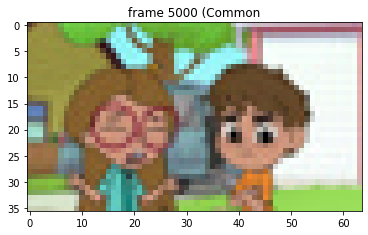

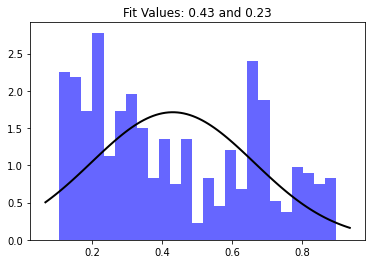

image key:tuttle_twins/s01e01/default_eng/v1/frames/stamps/TT_S01_E01_FRM-00-07-14-03.jpg shape:(36, 64, 3)


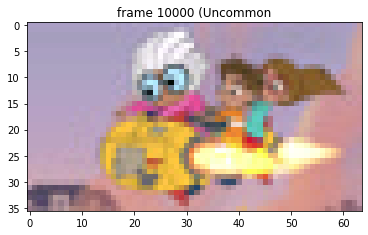

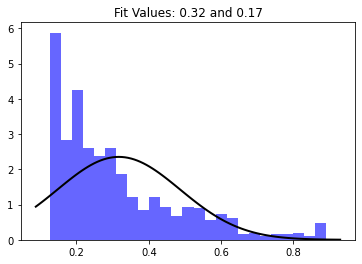

image key:tuttle_twins/s01e01/default_eng/v1/frames/stamps/TT_S01_E01_FRM-00-10-46-09.jpg shape:(36, 64, 3)


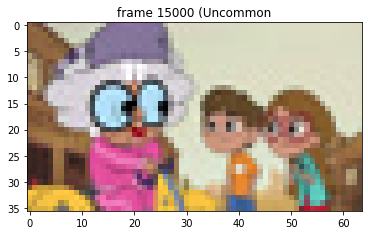

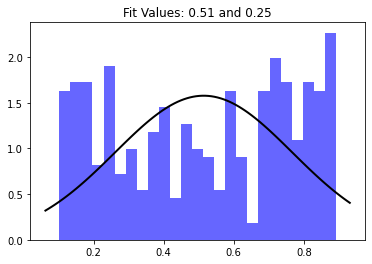

image key:tuttle_twins/s01e01/default_eng/v1/frames/stamps/TT_S01_E01_FRM-00-14-14-17.jpg shape:(36, 64, 3)


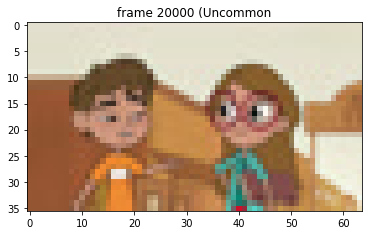

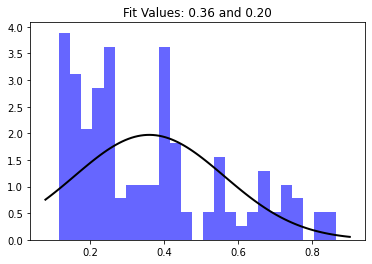

image key:tuttle_twins/s01e01/default_eng/v1/frames/stamps/TT_S01_E01_FRM-00-17-44-20.jpg shape:(36, 64, 3)


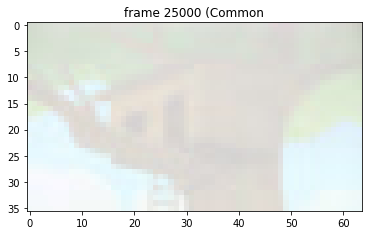

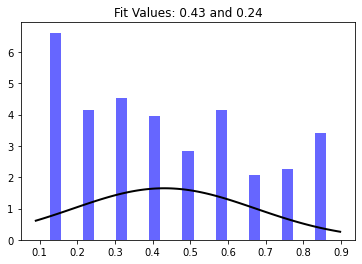

In [8]:
# upload manifest file
manifest_bucket = "media.angel-nft.com"
manifest_key = os.path.join('tuttle_twins/manifest', 'TT-S01-E01.csv')
src_file = "manifests/TT-S01-Manifest.csv"
s3_client.upload_file(src_file, manifest_bucket, manifest_key)

# process manifact file
process_manifest_file(manifest_bucket, manifest_key, 5000)
